# 機械学習モデルを解釈する指標SHAPを自然言語処理に対して使ってみた

テーブルデータに対するSHAPの使い方は以下の記事がきれいにまとまっており参考になります。

- [機械学習モデルを解釈する指標SHAPについて](https://ie110704.net/2019/04/26/%e6%a9%9f%e6%a2%b0%e5%ad%a6%e7%bf%92%e3%83%a2%e3%83%87%e3%83%ab%e3%82%92%e8%a7%a3%e9%87%88%e3%81%99%e3%82%8b%e6%8c%87%e6%a8%99shap%e3%81%ab%e3%81%a4%e3%81%84%e3%81%a6/)

公式のGithubのREADMEにも使い方を詳しく説明してくれてます。

- https://github.com/slundberg/shap

このSHAPはDeepLeaningのモデルにも使えるので、自然言語処理に対する適用方法を簡単にまとめてみます。
自然言語処理に対する適用方法は公式のチュートリアルが参考になります。

- https://shap.readthedocs.io/en/latest/text_examples.html

今回はhuggingfaceのBERT（bert-base-cased）をファインチューニングしたモデルに対してSHAPを適用してみようと思います。
扱うデータセットは[前回記事](https://qiita.com/m__k/items/335ea854c3753ac2dd5a)で紹介したhuggingfaceの`datasets`ライブラリから取得できる感情分類用の`emotion`データセットを使いたいと思います。

※SHAPの使い方（実装方法）に焦点を当てているため、SHAPの理論面には触れません。
詳しくは上記の参考記事や以下の元論文をご参照ください。

- [A Unified Approach to Interpreting Model Predictions](https://arxiv.org/abs/1705.07874)


# 準備

ファインチューニングされた感情分類BERTモデルを用意するところまでざっと以下の通り実装します。
BERTの使い方については[過去記事](https://qiita.com/m__k/items/e312ddcf9a3d0ea64d72)もご参照ください。

In [2]:
# datasetsから取得したデータセットをtsv形式で一旦保存したいので、保存先としてGoogle Driveをするためにマウントしてます。
# colabにGoogle Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 必要なライブラリをpipでインストール

!pip install shap # SHAPはpipで簡単にインストールできます
!pip install datasets
!pip install transformers

     |████████████████████████████████| 358kB 20.6MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491621 sha256=ebcc05aecb74beb69a3232312a3e7bca8ab3e25fe5f5ea7ce151e0a33ad007fd
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 194kB 18.1MB/s 
     |████████████████████████████████| 245kB 16.3MB/s 
     |████████████████████████████████| 112kB 49.0MB/s 
     |████████████████████████████████| 1.9MB 21.7MB/s 
     |████████████████████████████████| 890kB 51.7MB/s 
     |████████████████████████████████| 3.2MB 49.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=626d309adb73a500ab21c54d4821ebe67ac98596d83c433d75a876e0c398a3f1
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
# 必要な諸々のライブラリをインポートする
import shap
import datasets
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import scipy as sp
import random
from IPython.display import display, HTML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from transformers import BertModel
from transformers import BertTokenizer

# データセット格納先
drive_dir = "drive/My Drive/Colab Notebooks/emotion_dataset/"

In [5]:
# 一番プレーン？なBERTモデルを使う
# cased->大文字と小文字を区別しない
# uncased->大文字と小文字を区別する
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained("bert-base-cased")

In [6]:
# huggingfaceのdatasetsライブラリから感情分析のデータセット'emotion'を使う
emotion_dataset = datasets.load_dataset('emotion')

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/aa34462255cd487d04be8387a2d572588f6ceee23f784f37365aa714afeb8fe6. Subsequent calls will reuse this data.


In [7]:
# torchtextでDataLoaderを作成するので、一旦データセットをtsvファイルに保存する
# いちいちtsvファイルに保存しなくてもtorchtextで扱える方法があるのであれば、知らないだけです...

# まずはDataFrameに変換
# 学習データ
train_df = pd.DataFrame(emotion_dataset['train']['text'], columns=['text'])
train_df['label'] = emotion_dataset['train']['label']
# テストデータ
test_df = pd.DataFrame(emotion_dataset['test']['text'], columns=['text'])
test_df['label'] = emotion_dataset['test']['label']

# tsvファイルとして保存。保存先はマウントしたGoogle Drive
train_df.to_csv(drive_dir + 'train.tsv', sep='\t', index=False, header=None)
test_df.to_csv(drive_dir + 'test.tsv', sep='\t', index=False, header=None)

# 正解ラベルの数
# emotion datasetのラベルの数は6つです。
LABEL_NUM = len(set(train_df['label'])) 
# LABEL_NUM = 6

# ちなみに各ラベルの意味は以下の通りです。
labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

# 後ほど使うので、ラベルIDをラベルに変換、ラベルをラベルIDに変換する辞書をそれぞれ作成しておきます。
id2label = {i:labels[i] for i in range(len(labels))}
label2id = {label:labels.index(label) for label in labels}

In [8]:
# torchtextを使ってDataLoaderを作成

# 英語版のBERTはtokenizerのoutputが辞書形式で返却されるようで
# 分かち書きのtoken idのリストは'input_ids'キーに格納されています。
# BERT modelの引数に対応した形のようです。
# Reference: https://huggingface.co/transformers/model_doc/bert.html
print(tokenizer(train_df['text'][0]))
# {'input_ids': [101, 178, 1238, 1204, 1631, 21820, 21896, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

def encode(text):
    return tokenizer(text)['input_ids']

TEXT = torchtext.data.Field(sequential=True, tokenize=encode, use_vocab=False, lower=False, include_lengths=True, batch_first=True, pad_token=0)
LABEL = torchtext.data.Field(sequential=False, use_vocab=False)

train_data, test_data = torchtext.data.TabularDataset.splits(path=drive_dir, train='train.tsv', test='test.tsv', format='tsv', fields=[('Text', TEXT), ('Label', LABEL)])

BATCH_SIZE = 32
train_iter, test_iter = torchtext.data.Iterator.splits((train_data, test_data), batch_sizes=(BATCH_SIZE, BATCH_SIZE), repeat=False, sort=False)

{'input_ids': [101, 178, 1238, 1204, 1631, 21820, 21896, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [9]:
# BERTによる感情分類モデルを定義
class BertClassifier(nn.Module):
  def __init__(self, base_model, label_num):
    super(BertClassifier, self).__init__()
    self.bert = base_model
    # BERTのアウトプットの次元数は768次元、label_numは正解ラベルの数を指定する
    self.linear = nn.Linear(768, label_num) 

    # 重み初期化処理
    nn.init.normal_(self.linear.weight, std=0.02)
    nn.init.normal_(self.linear.bias, 0)

  def forward(self, encode_input):
    # Attentionの可視化も行いたいので、output_attentions=Trueを指定してます。
    output = self.bert(encode_input, output_attentions=True)

    # outputが辞書形式になっているので、必要な出力のキーを指定して取得する
    vec = output['last_hidden_state']
    attentions = output['attentions']

    # 先頭トークンCLSのベクトルだけ取得
    vec = vec[:,0,:]
    vec = vec.view(-1, 768)

    # 全結合層でクラス分類用に次元を変換
    vec = self.linear(vec)

    return F.log_softmax(vec, dim=1), attentions

classifier = BertClassifier(base_model=model, label_num=LABEL_NUM)

In [10]:
# ファインチューニングの設定
for param in classifier.parameters():
    param.requires_grad = False

# BERTモデルの最後の層を学習対象
for param in classifier.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

# 最後の全結合層を学習対象
for param in classifier.linear.parameters():
    param.requires_grad = True

In [11]:
# 最適化関数、損失関数の定義
optimizer = optim.Adam([
    {'params': classifier.bert.encoder.layer[-1].parameters(), 'lr': 5e-5},
    {'params': classifier.linear.parameters(), 'lr': 1e-4}
])

loss_function = nn.NLLLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classifier.to(device)

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [12]:
# 学習
# だいたい5エポックで精度(F1-score)は安定するっぽいです。
for epoch in range(5):
  all_loss = 0
  for idx, batch in enumerate(train_iter):
    batch_loss = 0
    classifier.zero_grad()
    input_ids = batch.Text[0].to(device)
    label_ids = batch.Label.to(device)
    out, _ = classifier(input_ids)
    batch_loss = loss_function(out, label_ids)
    batch_loss.backward()
    optimizer.step()
    all_loss += batch_loss.item()
  print("epoch", epoch, "\t" , "loss", all_loss)

epoch 0 	 loss 515.8919823169708
epoch 1 	 loss 200.9641254171729
epoch 2 	 loss 137.17445162683725
epoch 3 	 loss 95.40901855751872
epoch 4 	 loss 62.990102727897465


In [13]:
# 精度（F1-score）を確認
answer = []
prediction = []
with torch.no_grad():
    for batch in test_iter:

        text_tensor = batch.Text[0].to(device)
        label_tensor = batch.Label.to(device)

        score, _ = classifier(text_tensor)
        _, pred = torch.max(score, 1)

        prediction += list(pred.cpu().numpy())
        answer += list(label_tensor.cpu().numpy())
print(classification_report(prediction, answer, target_names=labels))
# surpriseは特にデータ数が少ないためにF1-scoreも悪い結果となっているようです。

              precision    recall  f1-score   support

     sadness       0.92      0.92      0.92       580
         joy       0.91      0.90      0.91       707
        love       0.77      0.73      0.75       166
       anger       0.87      0.91      0.89       264
        fear       0.82      0.88      0.85       210
    surprise       0.73      0.66      0.69        73

    accuracy                           0.88      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.88      0.88      0.88      2000



In [ ]:
# Attention可視化
def highlight(word, attn):
  html_color = '#%02X%02X%02X' % (255, int(255*(1 - attn)), int(255*(1 - attn)))
  return '<span style="background-color: {}">{}</span>'.format(html_color, word)

def mk_html(index, batch, preds, attention_weight):
  sentence = batch.Text[0][index]
  label =batch.Label[index].item()
  pred = preds[index].item()

  label_str = id2label[label]
  pred_str = id2label[pred]

  html = "正解カテゴリ: {}<br>予測カテゴリ: {}<br>".format(label_str, pred_str)

  # 文章の長さ分のzero tensorを宣言
  seq_len = attention_weight.size()[2]
  all_attens = torch.zeros(seq_len).to(device)

  for i in range(12):
    all_attens += attention_weight[index, i, 0, :]

  for word, attn in zip(sentence, all_attens):
    if tokenizer.convert_ids_to_tokens([word.tolist()])[0] == "[SEP]":
      break
    html += highlight(tokenizer.convert_ids_to_tokens([word.numpy().tolist()])[0], attn) + " "
  html += "<br><br>"
  return html

batch = next(iter(test_iter))
score, attentions = classifier(batch.Text[0].to(device))
_, pred = torch.max(score, 1)


for i in range(BATCH_SIZE):
  html_output = mk_html(i, batch, pred, attentions[-1])
  display(HTML(html_output))

# SHAPを使って、モデルを解釈してみる

公式リファレンスの[text example](https://shap.readthedocs.io/en/latest/text_examples.html)を参考に実装します。

GithubのREADMEをみる限り、TensorFlowやKerasのモデルであれば`shap.DeepExplainer`が使えるようですが（[KerasのLSTMモデルの例](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Keras%20LSTM%20for%20IMDB%20Sentiment%20Classification.html#)）、huggingfaceのtransformersは`shap.Explainer`を使えばいいようですね。

よさげな結果
1865

## shap.Explainerの使い方
引数がいくつかあり、それぞれの意味がよくわからなかったのですが、ソースコードにコメントで詳しい記載がされていたので、一部分を引用します。

```
class Explainer(Serializable):
    """ Uses Shapley values to explain any machine learning model or python function.

    This is the primary explainer interface for the SHAP library. It takes any combination
    of a model and masker and returns a callable subclass object that implements
    the particular estimation algorithm that was chosen.
    """

    def __init__(self, model, masker=None, link=links.identity, algorithm="auto", output_names=None, feature_names=None, **kwargs):
        """ Build a new explainer for the passed model.

        Parameters
        ----------
        model : object or function
            User supplied function or model object that takes a dataset of samples and
            computes the output of the model for those samples.

        masker : function, numpy.array, pandas.DataFrame, tokenizer, None, or a list of these for each model input
            The function used to "mask" out hidden features of the form `masked_args = masker(*model_args, mask=mask)`. 
            It takes input in the same form as the model, but for just a single sample with a binary
            mask, then returns an iterable of masked samples. These
            masked samples will then be evaluated using the model function and the outputs averaged.
            As a shortcut for the standard masking using by SHAP you can pass a background data matrix
            instead of a function and that matrix will be used for masking. Domain specific masking
            functions are available in shap such as shap.ImageMasker for images and shap.TokenMasker
            for text. In addition to determining how to replace hidden features, the masker can also
            constrain the rules of the cooperative game used to explain the model. For example
            shap.TabularMasker(data, hclustering="correlation") will enforce a hierarchial clustering
            of coalitions for the game (in this special case the attributions are known as the Owen values).

        link : function
            The link function used to map between the output units of the model and the SHAP value units. By
            default it is shap.links.identity, but shap.links.logit can be useful so that expectations are
            computed in probability units while explanations remain in the (more naturally additive) log-odds
            units. For more details on how link functions work see any overview of link functions for generalized
            linear models.

        algorithm : "auto", "permutation", "partition", "tree", "kernel", "sampling", "linear", "deep", or "gradient"
            The algorithm used to estimate the Shapley values. There are many different algorithms that
            can be used to estimate the Shapley values (and the related value for constrained games), each
            of these algorithms have various tradeoffs and are preferrable in different situations. By
            default the "auto" options attempts to make the best choice given the passed model and masker,
            but this choice can always be overriden by passing the name of a specific algorithm. The type of
            algorithm used will determine what type of subclass object is returned by this constructor, and
            you can also build those subclasses directly if you prefer or need more fine grained control over
            their options.

        output_names : None or list of strings
            The names of the model outputs. For example if the model is an image classifier, then output_names would
            be the names of all the output classes. This parameter is optional. When output_names is None then
            the Explanation objects produced by this explainer will not have any output_names, which could effect
            downstream plots.
        """

```

まだいまいち理解しきれていないところがありますが、今回は`model`、`masker`、`output_names`を指定して動かしています。

`model`はちょっと注意が必要です。今回でいうと、分類モデルのインスタンス`classifier`を指定ちゃいたくなりますが、こいつのインプットは自然文をid列に変換したテンソルです。id列に対してSHAP値を求めても、なんの単語や文章が出力に効いているかよくわからないので、`model`には自然文をインプットできる形式で書き換えてあげる必要があります。

`masker`にはトークナイザーを指定してやればよいようで、`model`で指定したモデルと同じインプットで動くものを指定します。今回で言えばBERTモデルのトークナイザーのインスタンス`tokenizer`
をそのまま指定しています。

`output_names`は正解ラベルで使っていたラベルの配列を指定します。

In [15]:
# shap.Explainerの引数modelに指定する関数を以下で定義
# 引数のsentencesは自然文の配列を想定しています。
# 自然文が1つだけの時はその文章を配列に変換してから使います。
# max_lengthはテストデータの最大長さを指定しています。
def f(sentences):
    input_ids = torch.tensor([tokenizer.encode(text, padding='max_length', max_length=68) for text in sentences]).to(device)
    with torch.no_grad():
        out, _ = classifier(input_ids)
    return out.detach().cpu()

# SHAP値を計算するインスタンスを生成する
explainer = shap.Explainer(model=f, masker=tokenizer, output_names=labels)

# あとはSHAP値を計算したい自然分の配列をexplainerに渡せばOK
# 後ほど実行するのでここではコメントアウト
# shap_values = explainer(sentences)

## Attentionとの比較も行ってみる
自然言語処理における説明性の可視化と言えばAttentionが思い浮かぶかと思います。
SHAPの可視化と同時に、どの単語がAttentionされているかも見比べてみようと思います。


In [16]:
# SHAP値を算出するときと同様の方法でAttentionの結果を得られる関数を定義しておく
def f_a(sentences):
    input_ids = torch.tensor([tokenizer.encode(text, padding='max_length', max_length=68) for text in sentences]).to(device)
    with torch.no_grad():
        _, attn = classifier(input_ids)
    return input_ids[0].detach().cpu(), attn[-1].detach().cpu()

# 以下2つの関数はAttentionの結果を単語にハイライトするためのものです。
# 以前書いた記事で使っていた関数を今回用に書き換えています。
def highlight(word, attn):
  html_color = '#%02X%02X%02X' % (255, int(255*(1 - attn)), int(255*(1 - attn)))
  return '<span style="background-color: {}">{}</span>'.format(html_color, word)

def mk_html(input_ids, attention_weight):
    # 文章の長さ分のzero tensorを宣言
    seq_len = attention_weight.size()[2]
    all_attens = torch.zeros(seq_len)

    for i in range(12):
        all_attens += attention_weight[0, i, 0, :]

    html = ""
    for word, attn in zip(input_ids, all_attens):
        if tokenizer.convert_ids_to_tokens([word.tolist()])[0] == "[SEP]":
            break
        html += highlight(tokenizer.convert_ids_to_tokens([word.numpy().tolist()])[0], attn) + " "
    
    return html
# idx = 1865
# sentence = test_df['text'][idx]

# input_ids, attn = f_a([sentence])
# print(input_ids)
# tokenizer.convert_ids_to_tokens(input_ids[0])

# 1つの文章に対して使ってみる

In [18]:
# idx = random.randint(0,len(test_df))
idx = 1865
sentence = test_df['text'][idx]
answer = id2label[test_df['label'][idx]]
predict = id2label[f([sentence]).argmax().item()]

# Attentionの計算
input_ids, attention = f_a([sentence])

print("元文章", sentence)
print("正解ラベル", answer)
print("予測ラベル", predict)

# SHAP値を計算する
# sentenceは１文章だけなので、[]で囲って配列として渡してます。
shap_values = explainer([sentence])

元文章 i dont know if i should let go and feel that vain or should i wait and stay in vain
正解ラベル sadness
予測ラベル sadness


In [22]:
# Attention可視化
print("■Attentionの可視化結果")
html_output = mk_html(input_ids, attention)
display(HTML(html_output))
print()

print("■SHAPの可視化結果")
# shap.plots.textに計算したSHAP値を渡します。
# どの単語や句が予測ラベルにどれくらい（プラスの方向、マイナスの方向に）効いていたかを可視化します。
# 赤がプラス、青がマイナスの方向を表現しており、濃淡は度合いを表しています。
shap.plots.text(shap_values[0,:,predict])

■Attentionの可視化結果



■SHAPの可視化結果


In [23]:
# 以下のように、ラベルを指定しなければ、全ラベルに対して、各単語や句がどのラベルに効いていたかをHeat map形式でみることができます。
shap.plots.text(shap_values[0,:,])

,,i dont know if i should,let go and,feel that vain or,should i wait and,stay in vain,
sadness,-0.0,-0.92,0.15,2.5,-0.077,1.818,0.0
joy,-0.0,0.353,0.051,-2.319,-0.468,-2.373,0.0
love,0.0,-0.42,-0.246,-1.096,-0.04,-1.548,0.0
anger,-0.0,-0.687,-0.38,-0.876,0.096,-2.642,0.0
fear,0.0,-1.548,-0.358,-0.332,-0.762,-2.091,0.0
surprise,0.0,-2.127,-0.459,-2.277,-0.591,-1.879,0.0


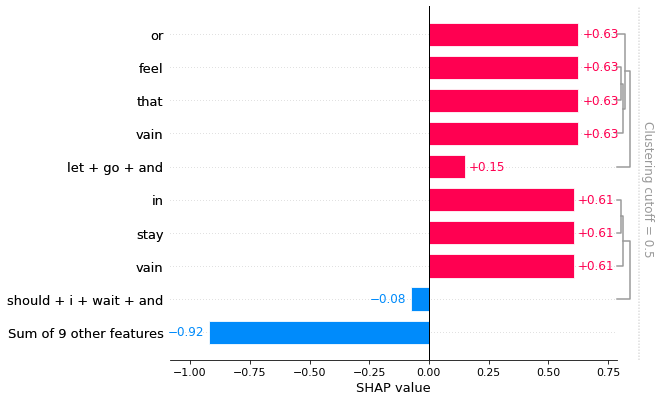

In [24]:
# 棒グラフで可視化することもできます。
shap.plots.bar(shap_values[0,:,predict])

In [48]:
# 別の文章でも試してみる
# idx = random.randint(0,len(test_df))
idx = 1952
sentence = test_df['text'][idx]
answer = id2label[test_df['label'][idx]]
predict = id2label[f([sentence]).argmax().item()]

# Attentionの計算
input_ids, attention = f_a([sentence])

print("元文章", sentence)
print("正解ラベル", answer)
print("予測ラベル", predict)

# SHAP値を計算する
# sentenceは１文章だけなので、[]で囲って配列として渡してます。
shap_values = explainer([sentence])

元文章 i am feeling a little apprehensive about the whole thing
正解ラベル fear
予測ラベル fear


In [64]:
# Attention可視化
print("■Attentionの可視化結果")
html_output = mk_html(input_ids, attention)
display(HTML(html_output))
print()

print("■SHAPの可視化結果")
# shap.plots.textに計算したSHAP値を渡します。
# どの単語や句が予測ラベルにどれくらい（プラスの方向、マイナスの方向に）効いていたかを可視化します。
# 赤がプラス、青がマイナスの方向を表現しており、濃淡は度合いを表しています。
shap.plots.text(shap_values[0,:,predict], group_threshold=0, separator="@")

■Attentionの可視化結果



■SHAPの可視化結果


In [69]:
shap_values[0,:,'fear']

.values =
array([ 3.57627869e-06, -1.04328986e-01, -1.04328986e-01, -1.04328986e-01,
       -1.04328986e-01, -1.04328986e-01,  3.90341460e-01,  3.90341460e-01,
        8.72272146e-01,  8.72272146e-01,  1.17938513e-01,  1.17938513e-01,
        1.17938513e-01,  1.17938513e-01,  1.19209290e-06])

.base_values =
-2.4755501747131348

.data =
array([' ', 'i ', 'am ', 'feeling ', 'a ', 'little ', 'app ', '##re ',
       '##hen ', '##sive ', 'about ', 'the ', 'whole ', 'thing ', ' '],
      dtype='<U8')

In [28]:
# 以下のように、ラベルを指定しなければ、全ラベルに対して、各単語や句がどのラベルに効いていたかをHeat map形式でみることができます。
shap.plots.text(shap_values[0,:,])

,,i am feeling a little,appre,##hensive,about the whole thing,
sadness,0.0,-0.012,-3.182,-2.766,-0.058,-0.0
joy,-0.0,-1.146,-3.958,-5.733,-1.025,0.0
love,0.0,0.841,-2.287,-3.068,-1.33,-0.0
anger,0.0,-1.191,-2.578,-2.259,-1.167,-0.0
fear,0.0,-0.522,0.781,1.745,0.472,0.0
surprise,0.0,-2.317,-2.239,-2.626,-0.34,-0.0


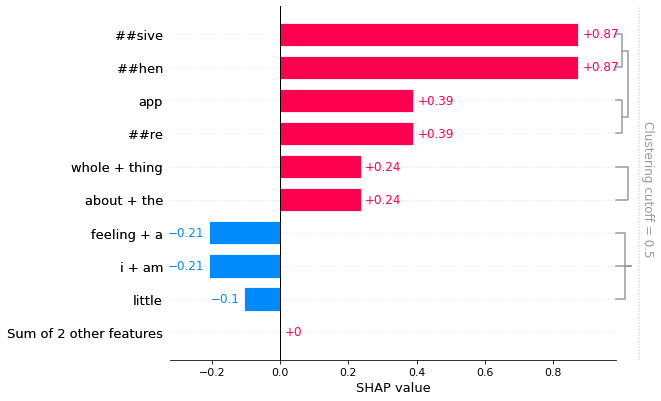

In [29]:
# 棒グラフで可視化することもできます。
shap.plots.bar(shap_values[0,:,predict])

# 特定のラベル全文を突っ込んでみる

公式リファレンスでやってるみたいに、複数の文章のSHAP値をまとめて計算して、SHAP値を可視化することで、特定のラベルによく効く単語を調べることができます。そのラベルの重要語の抽出といったところでしょうか。

In [25]:
# 予測が正しかった文章のみを抽出したり、予測と正解が間違っていた文章を抽出したいので、
# テストデータの各文章に対して予測ラベルを付与しておく
predict_list = []
for i in range(0, len(test_df), 10):
    _s = test_df['text'][i:i+10]
    predict_list += f(_s).argmax(dim=1).tolist()
test_df['pred'] = predict_list
# ちなみにこの予測結果と上でF1-scoreを算出したときの結果は微妙に異なります。
# 上で算出したときはpaddingはtorchtextが行った結果を使っており、ミニバッチ毎のmax_lengthでpaddingされていたかと思いますが、
# こちらで算出した結果は、全文章に対してmax_length128でpaddingして（全文章の長さがpadding込みで128になって）おり、
# classifierに通すデータが異なっているのが原因と思われます。
# とりあえず細かいことは気にしない精神で実装してます、ご容赦いただけたらと思います。。。
test_df.head()

,text,label,pred
0,im feeling rather rotten so im not very ambiti...,0,0
1,im updating my blog because i feel shitty,0,0
2,i never make her separate from me because i do...,0,0
3,i left with my bouquet of red and yellow tulip...,1,1
4,i was feeling a little vain when i did this one,0,0


In [70]:
print(classification_report(test_df['label'], test_df['pred']))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       581
           1       0.90      0.92      0.91       695
           2       0.74      0.77      0.76       159
           3       0.90      0.88      0.89       275
           4       0.88      0.82      0.85       224
           5       0.66      0.79      0.72        66

    accuracy                           0.88      2000
   macro avg       0.83      0.85      0.84      2000
weighted avg       0.88      0.88      0.88      2000



In [37]:
# loveと予測した文章全てのSHAP値を計算してみる
target_label = "love"
label_id = label2id[target_label]
sentences = test_df.query('pred == @label_id')['text']

# ぼちぼち時間かかります。
shap_values = explainer(sentences)

Partition explainer: 165it [00:45,  3.62it/s]


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


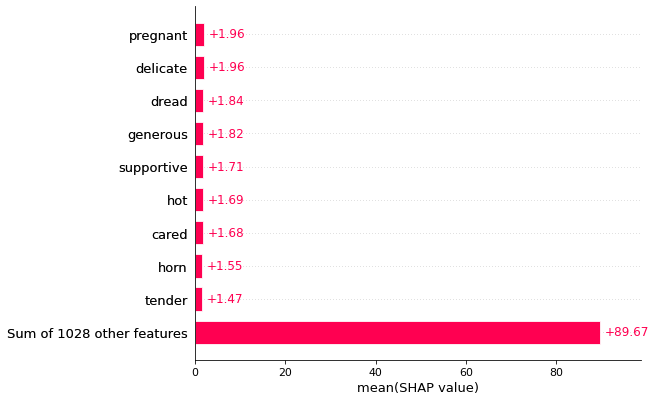

In [38]:
# SHAP値の高い順番に可視化してみる。
shap.plots.bar(shap_values[:,:,'love'].mean(0), max_display=10)

In [40]:
# angerでも試してみる
target_label = "anger"
label_id = label2id[target_label]
sentences = test_df.query('pred == @label_id')['text']

shap_values = explainer(sentences)

Partition explainer: 269it [01:13,  3.65it/s]


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


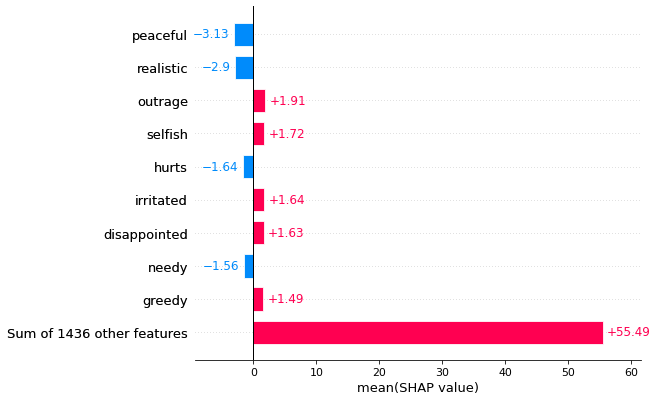

In [41]:
# SHAP値の高い順番に可視化してみる。
shap.plots.bar(shap_values[:,:,'anger'].mean(0), max_display=10)